In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import splat
import astropy.units as u
import popsims
splat.initializeStandards(all=True)
from scipy import interpolate
from tqdm import tqdm
%matplotlib inline

In [2]:
#read in Zhang samples
files=glob.glob('/users/caganze/research/wisps/data/primevalspectra/*.fits')

In [3]:
len(files)

92

In [4]:
def get_spectrum(f):
    try:
        hdu=fits.open(f)[0]
        wave=np.array([hdu.header['CRVAL1']+hdu.header['CDELT1']*x for x \
          in range(0, hdu.header['NAXIS1'])])*u.angstrom.to(u.micron)
        flux= hdu.data*u.erg/(u.cm**2 * u.s * u.micron)
        s=splat.Spectrum(wave=wave, flux=flux, noise=flux/1000, name=f.split('/')[-1])
        #s.smooth(150)
        #s.toInstrument('SpeX')
        #plt.plot(s.wave, s.flux)
        return s
    except:
        print ('could not read file {}'.format(f))
        return None

In [5]:
def interpolated_standards():
    stds=splat.STDS_DWARF_SPEX
    interpstds={}
    for k in stds.keys():
        s=stds[k]
        print (k)
        s.normalize()
        s.toInstrument('WFC3-G141')
        interpstds[k]=(interpolate.interp1d(s.wave.value, s.flux.value), interpolate.interp1d(s.wave.value, s.noise.value))
    return interpstds

In [6]:
spectra=[ get_spectrum(f) for f in tqdm(files)]

 65%|██████▌   | 60/92 [00:18<00:06,  4.62it/s]

could not read file /users/caganze/research/wisps/data/primevalspectra/ULAS_J130710.22+151103.4_sdL8_Xshooter_NIR_Primeval-IV.fits


 67%|██████▋   | 62/92 [00:20<00:10,  2.76it/s]

could not read file /users/caganze/research/wisps/data/primevalspectra/ULAS_J135058.85+081506.8_usdL3_Xshooter_NIR_Primeval-III.fits


 83%|████████▎ | 76/92 [00:21<00:02,  5.52it/s]

could not read file /users/caganze/research/wisps/data/primevalspectra/ULAS_J135058.85+081506.8_usdL3_Xshooter_VIS_Primeval-III.fits
could not read file /users/caganze/research/wisps/data/primevalspectra/ULAS_J020858.62+020657.0_esdL3_Xshooter_VIS_Primeval-III.fits


100%|██████████| 92/92 [00:24<00:00,  3.72it/s]


In [19]:
#visually confirmed templates
visual_sds=pd.read_pickle('/volumes/LaCie/wispsdata/db/subdwarfs_templates.pkl')

In [31]:
spectra=[s for s in spectra if s is not None]
sp_designations=[s.name.split('_')[1] for s in spectra]
sp_types=[s.name.split('_')[2] for s in spectra]

In [52]:
def return_sptype(optp, nirtp):
    if optp.lower() =='nan':
        return nirtp
    else:
        return optp
visual_types=[ return_sptype(x, y) for x, y in zip(visual_sds.opt_type.astype(str).values,\
                                                   visual_sds.spex_type.astype(str).values)]

In [56]:
#

In [57]:
combined_df=pd.DataFrame()
combined_df['spectra']=np.concatenate([spectra, visual_sds.splat_spectra.values])
combined_df['sptype']=np.concatenate([sp_types, visual_types])

In [59]:
combined_df.to_pickle(popsims.DATA_FOLDER+'/combined_sd_templates.pkl')

In [6]:
import glob
import splat
kast_path='/users/caganze/research/kastredux/kastredux/resources/spectral_standards/*'

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


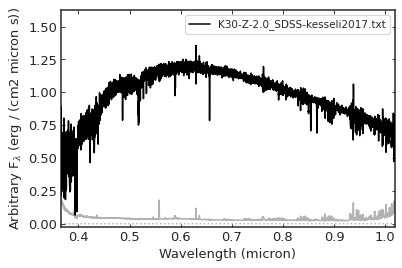

[<Figure size 432x288 with 1 Axes>]

In [20]:
s.plot()

In [31]:
def read_kast_spectra(file):
    try:
        s=splat.Spectrum(filename=file, wunit=u.Angstrom)
        s.toWaveUnit(u.micron)
        return s
    except:
        return None
    
def get_spectraltype(s):
    if s is None: return None
    else: return s.name.split(' ')[-1].split('_')[0]

In [32]:
files=glob.glob(kast_path)
spectra=[read_kast_spectra(x) for x in files]

In [34]:
#

In [33]:
kast_df=pd.DataFrame()
kast_df['spectra']=spectra
kast_df['sptype']=[get_spectraltype(s) for s in spectra]

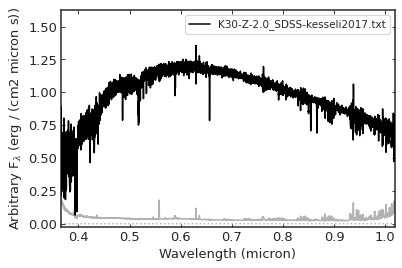

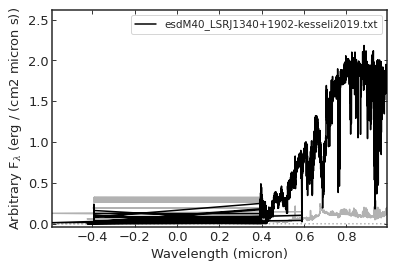

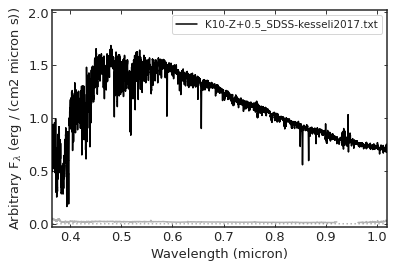

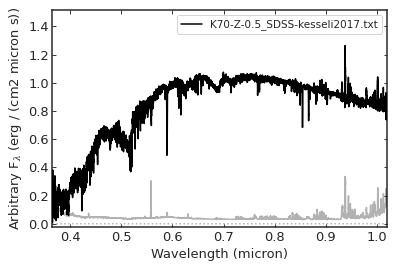

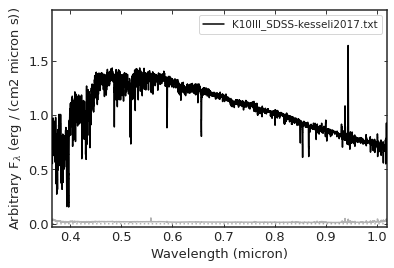

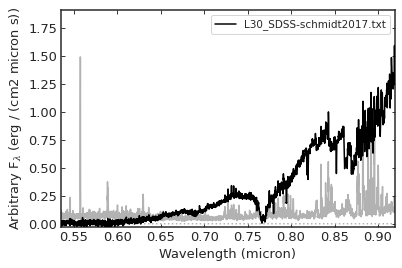

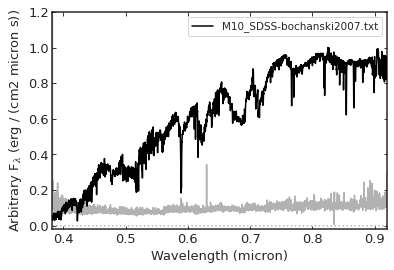

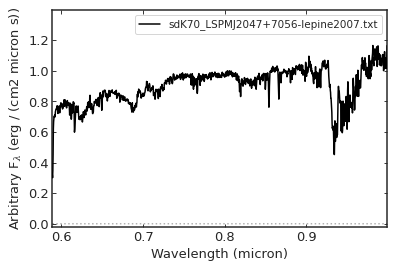

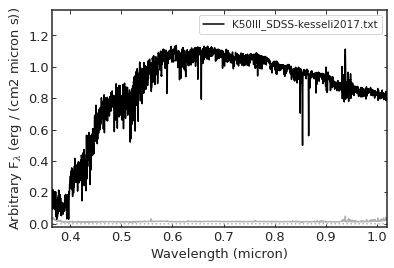

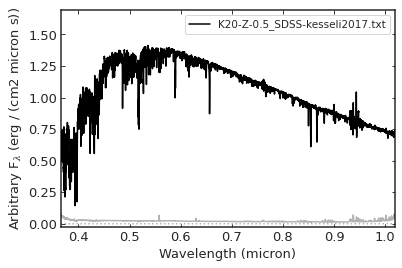

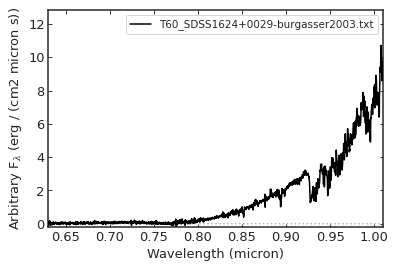

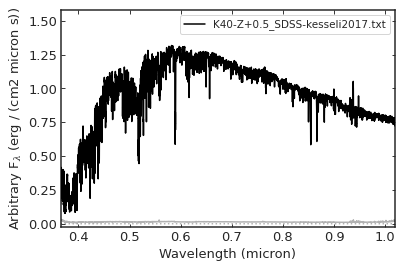

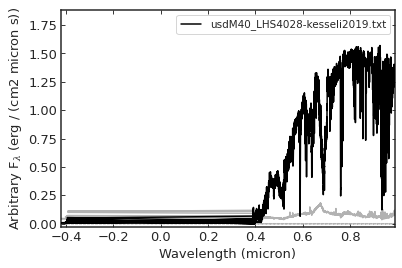

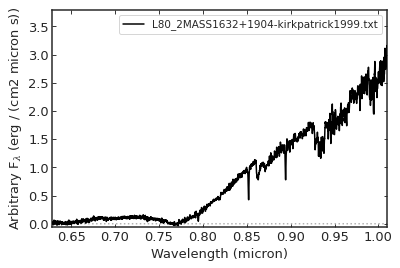

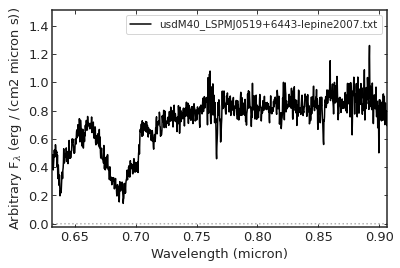

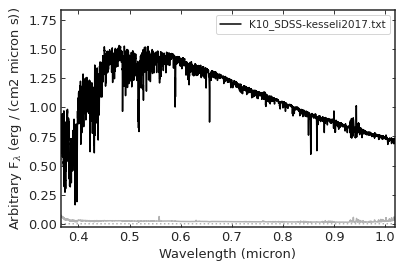

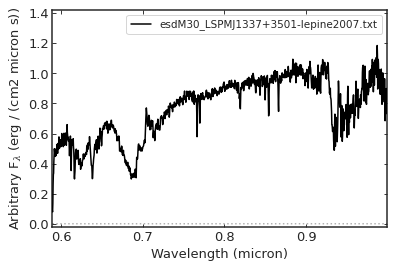

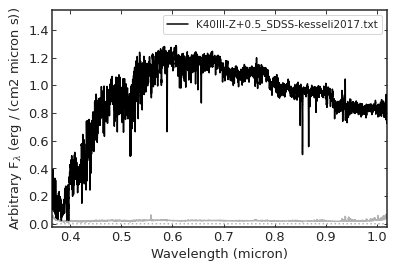

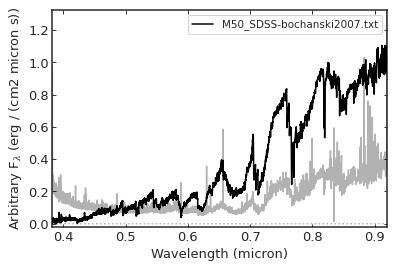

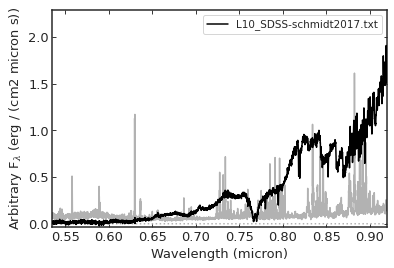

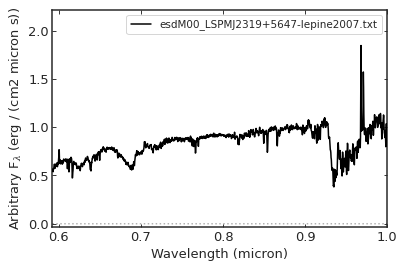

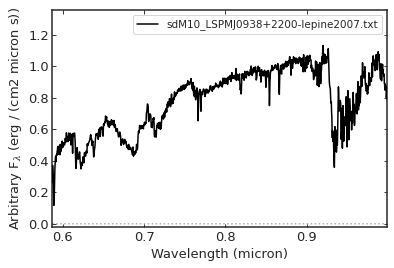

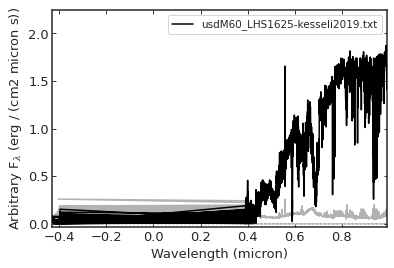

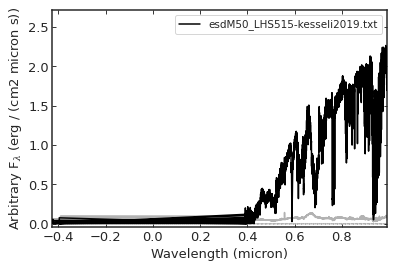

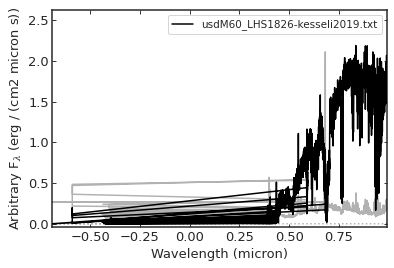

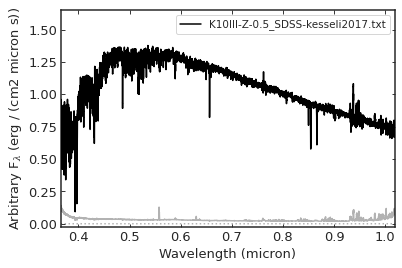

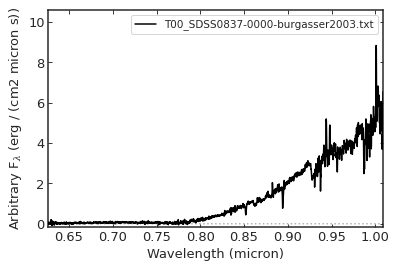

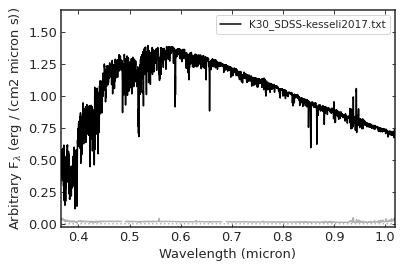

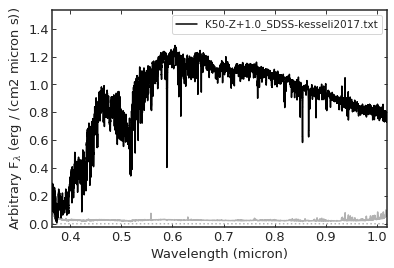

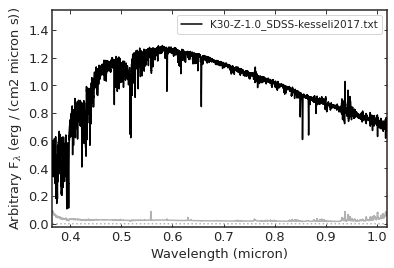

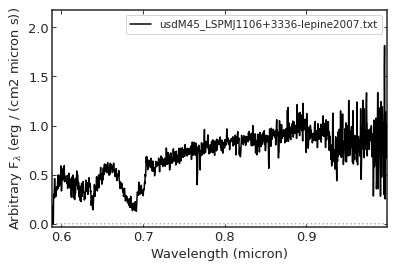

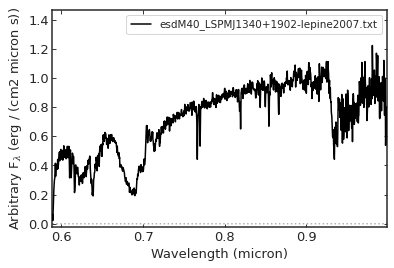

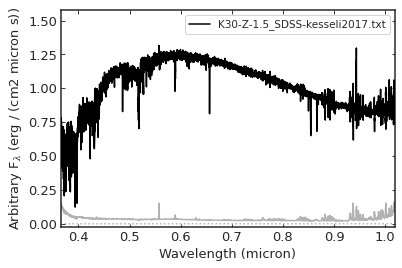

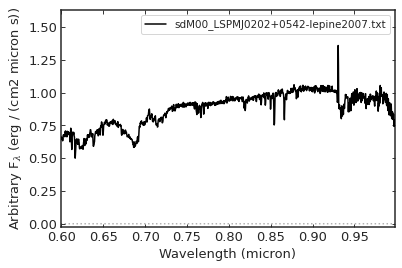

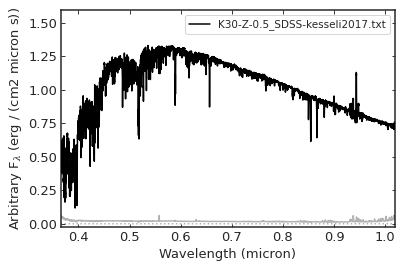

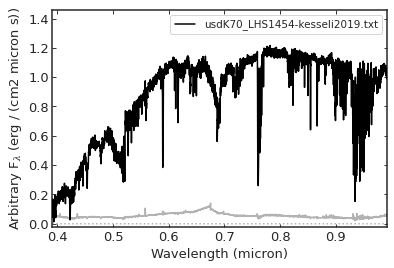

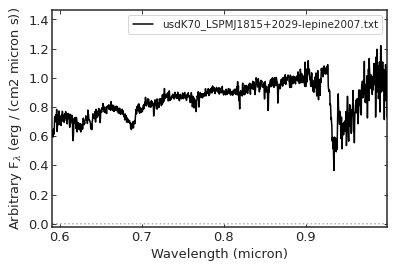

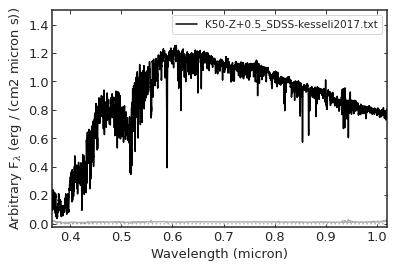

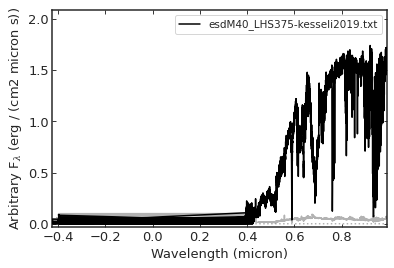

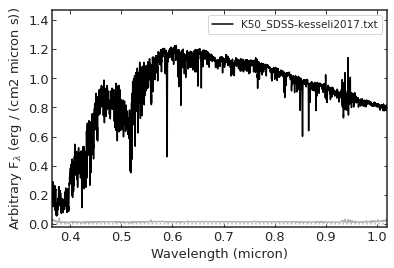

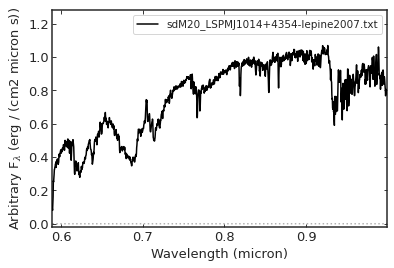

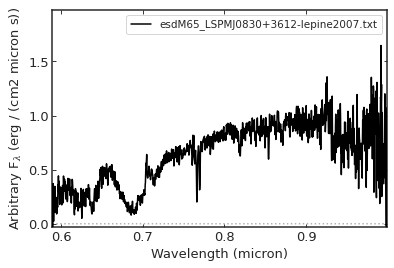

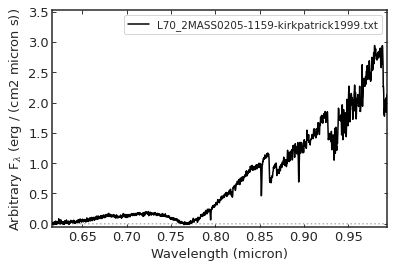

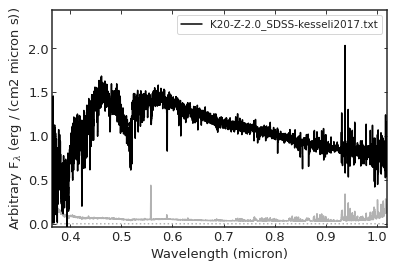

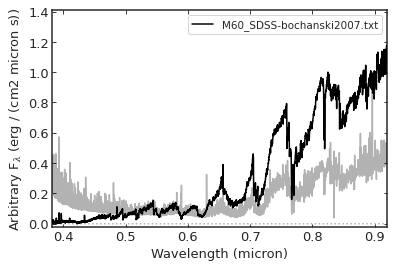

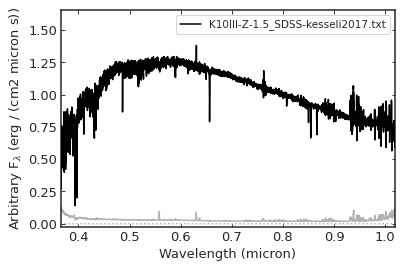

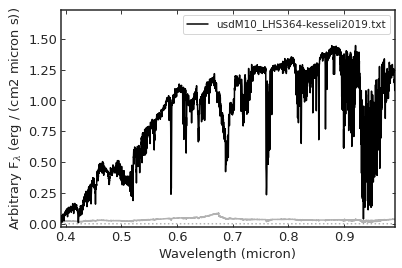

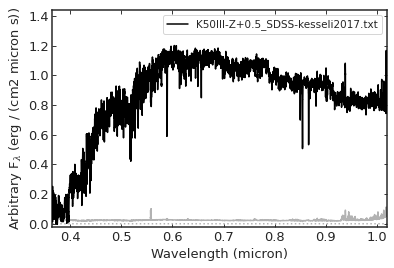

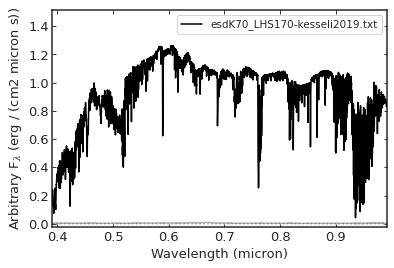

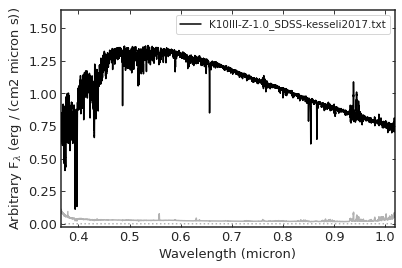

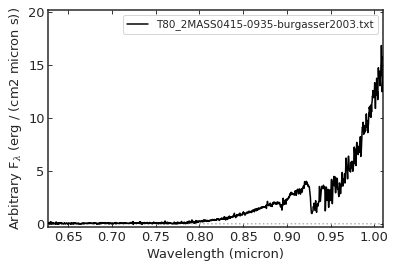

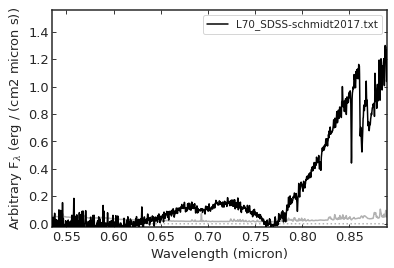

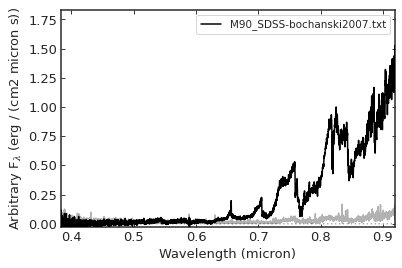

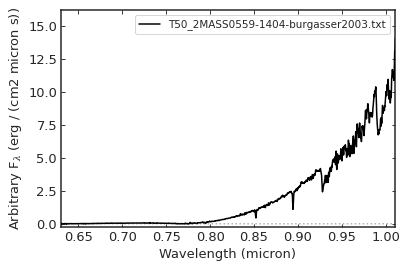

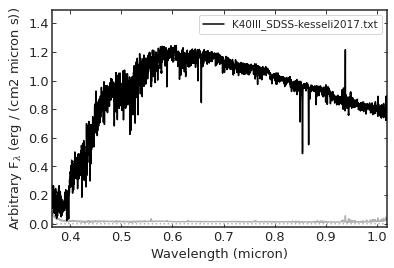

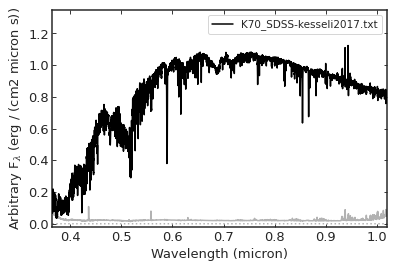

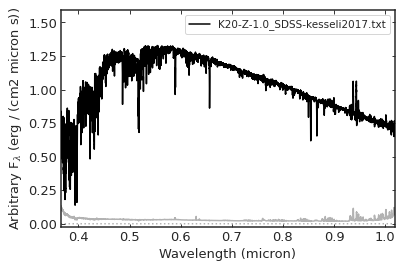

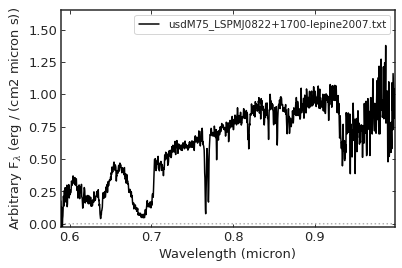

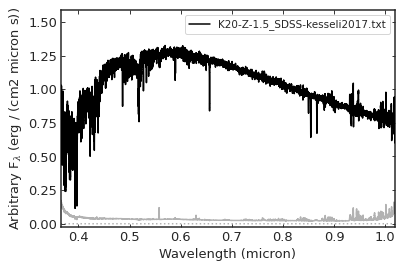

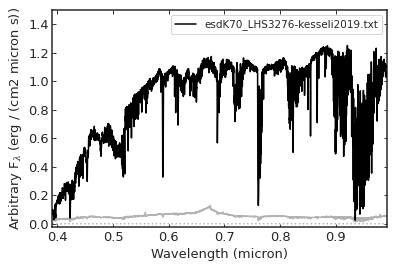

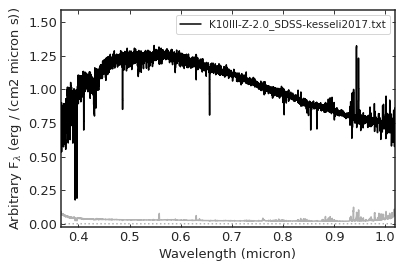

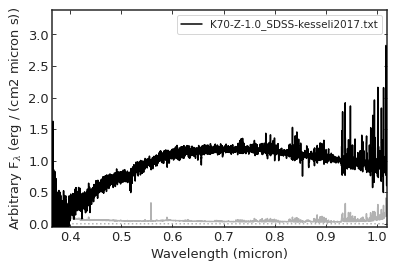

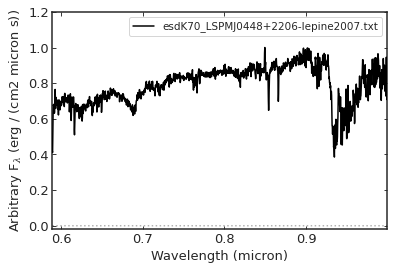

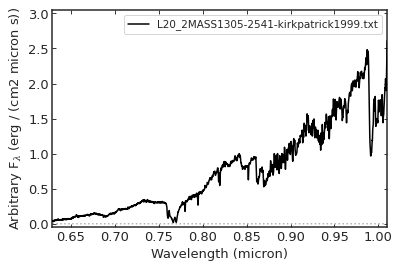

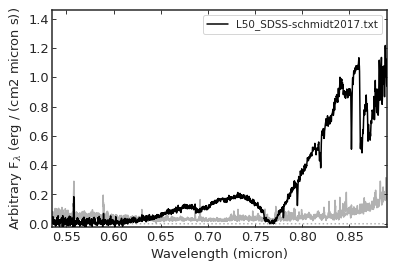

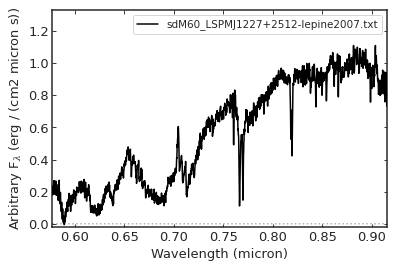

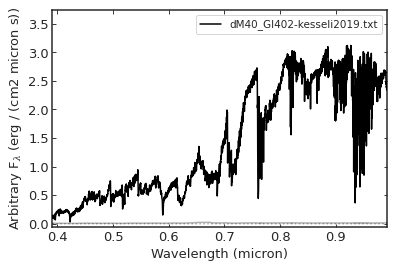

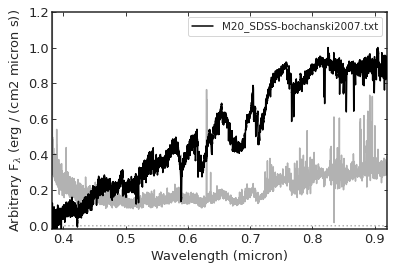

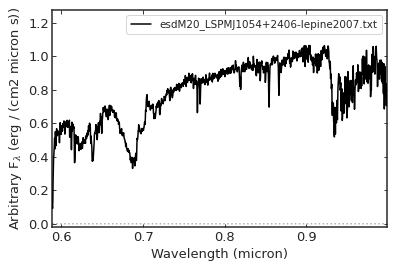

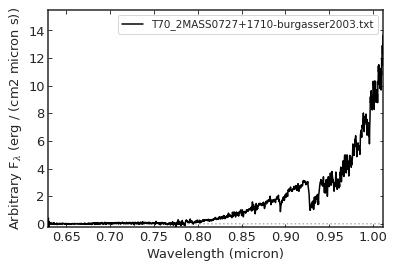

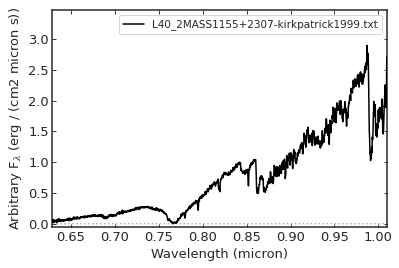

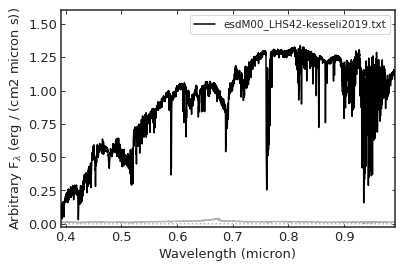

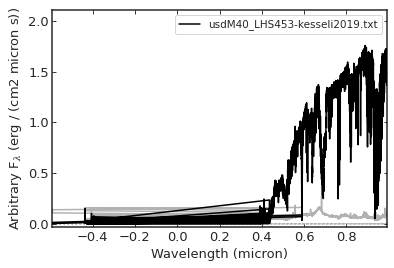

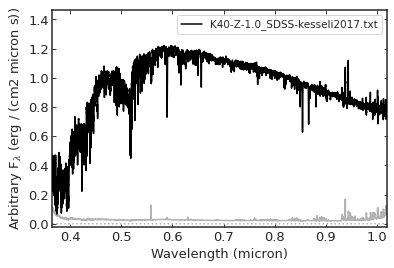

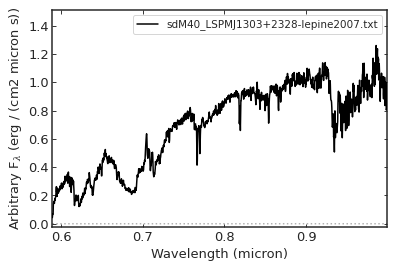

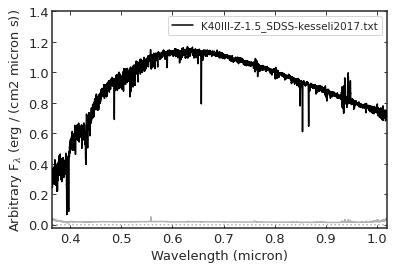

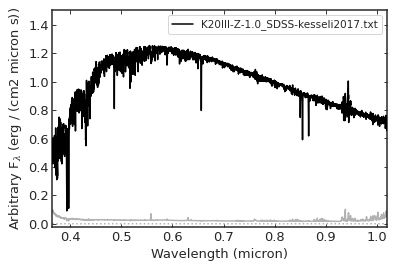

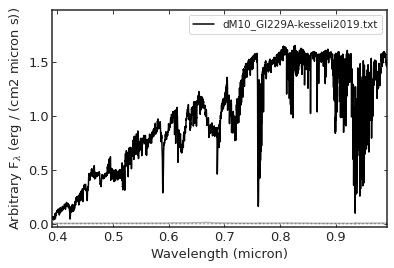

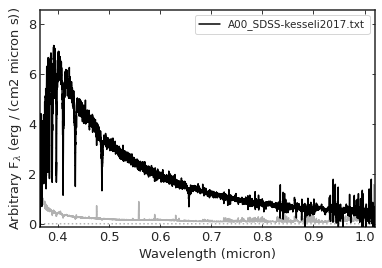

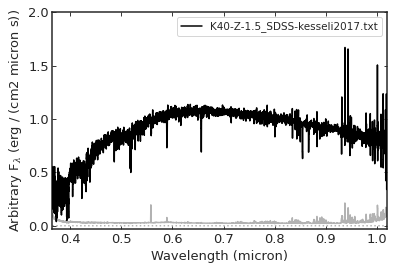

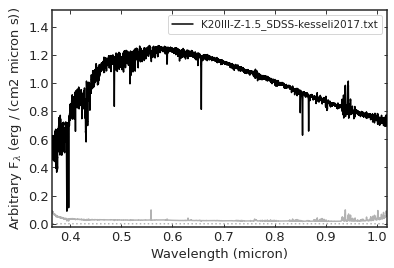

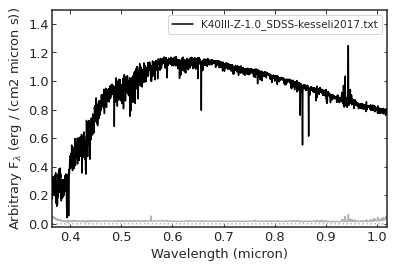

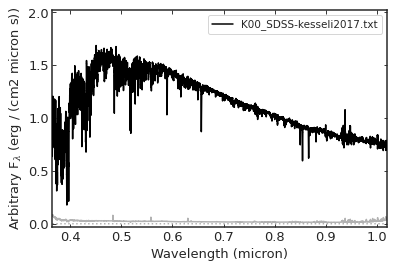

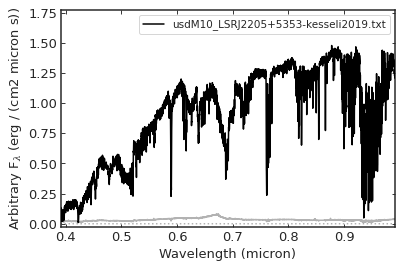

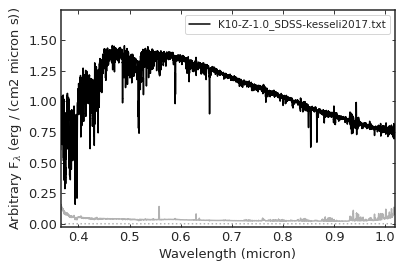

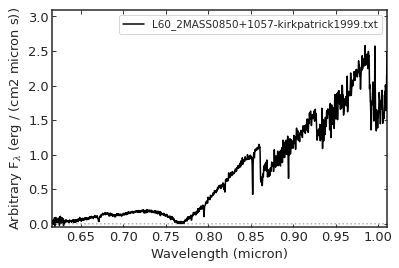

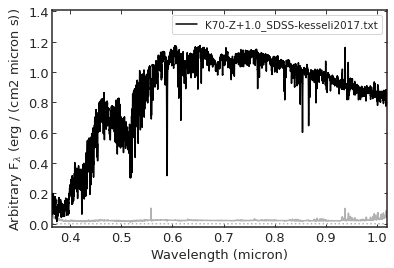

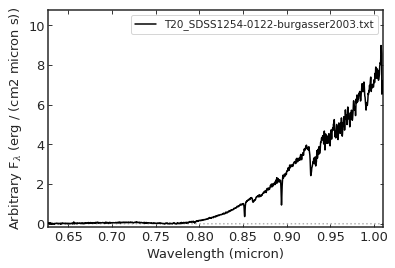

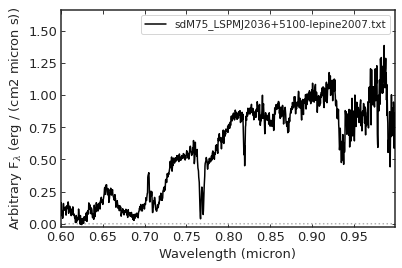

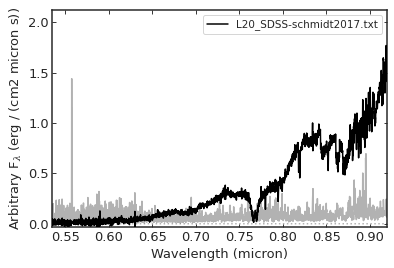

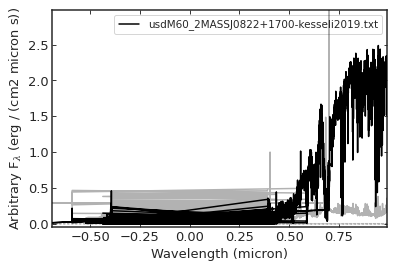

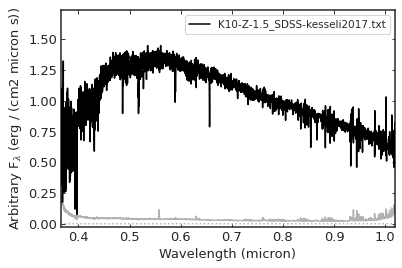

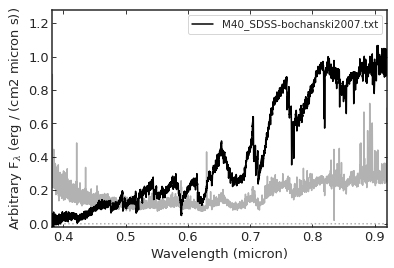

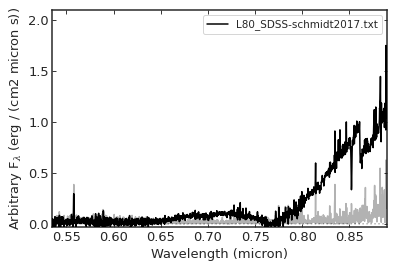

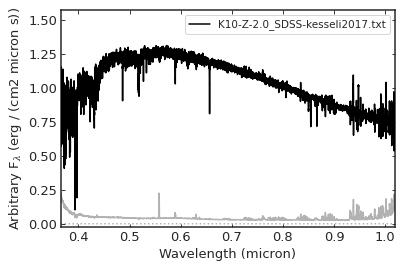

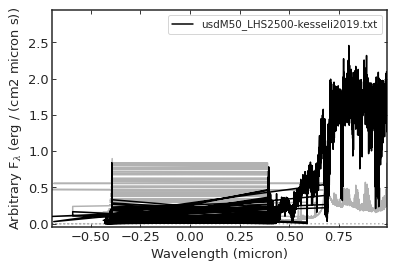

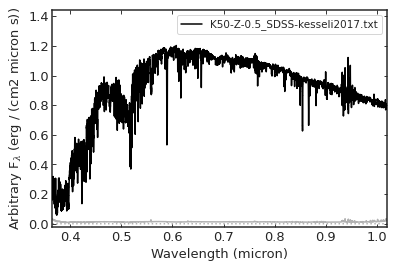

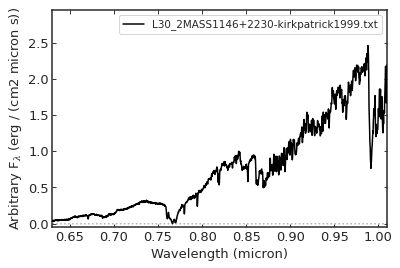

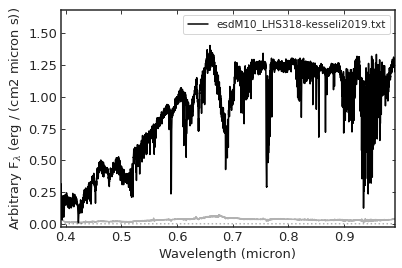

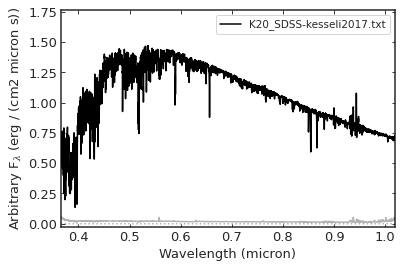

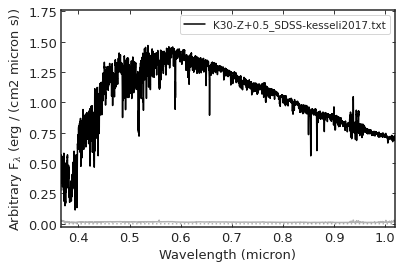

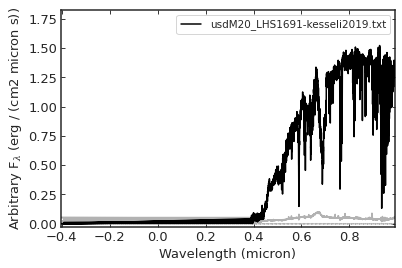

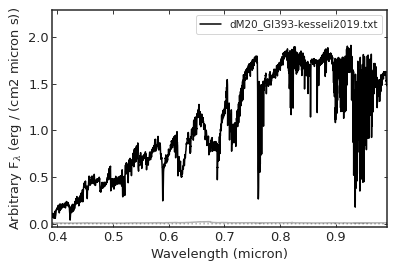

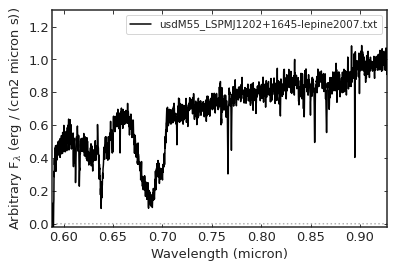

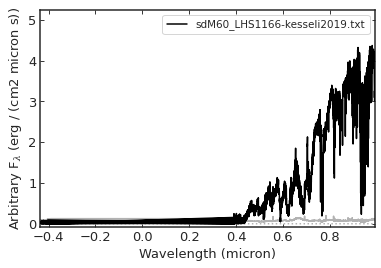

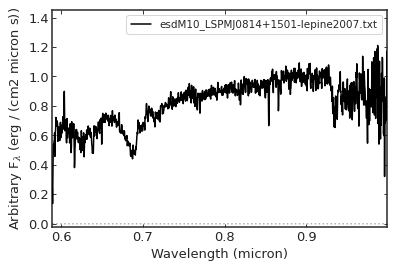

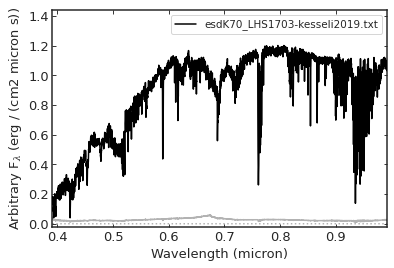

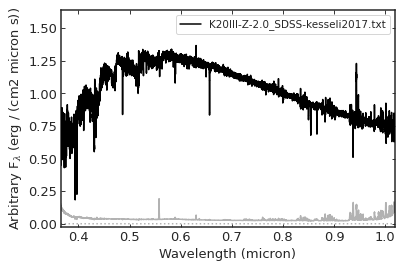

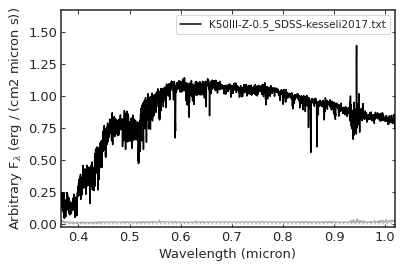

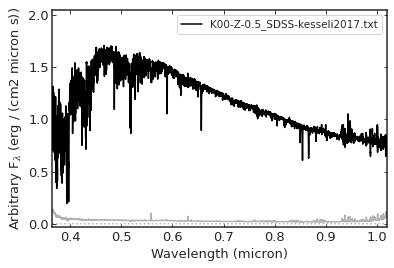

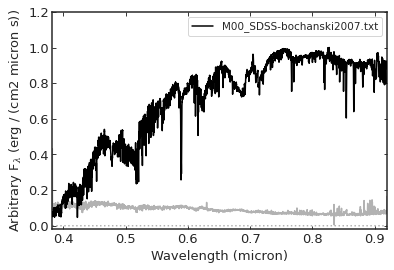

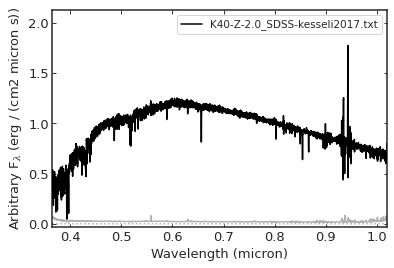

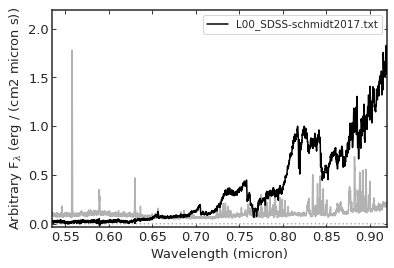

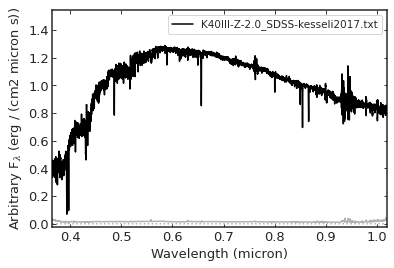

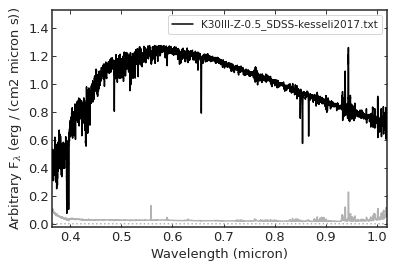

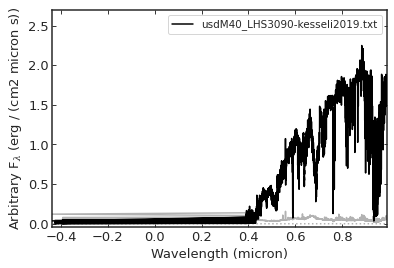

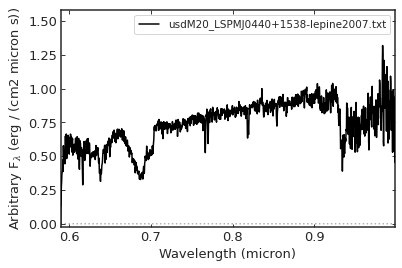

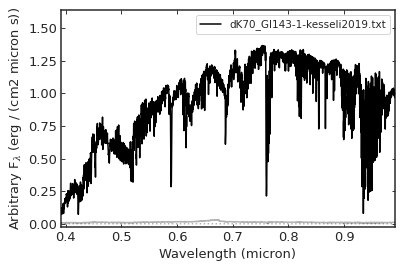

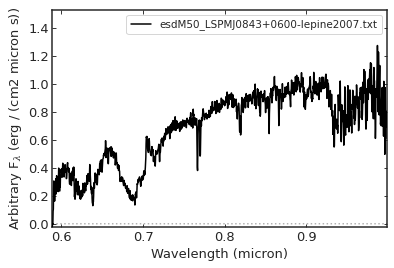

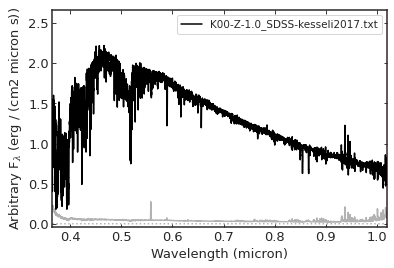

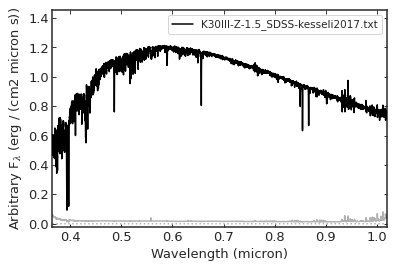

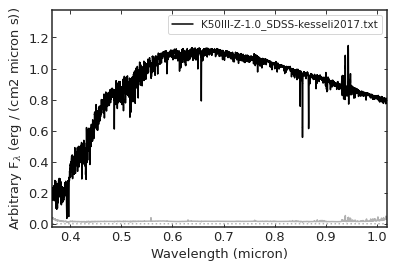

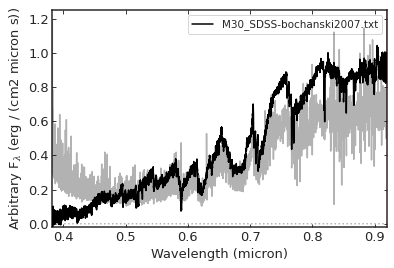

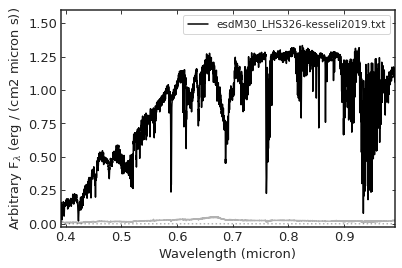

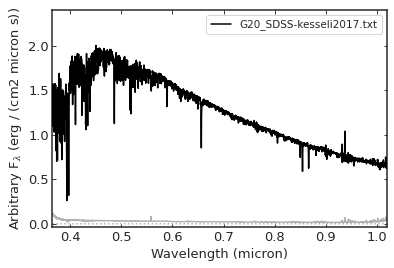

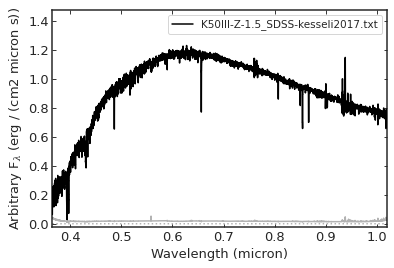

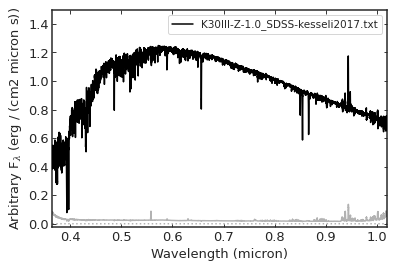

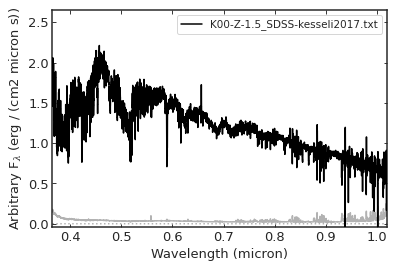

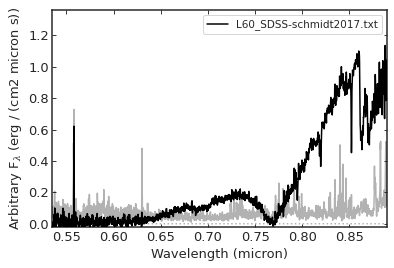

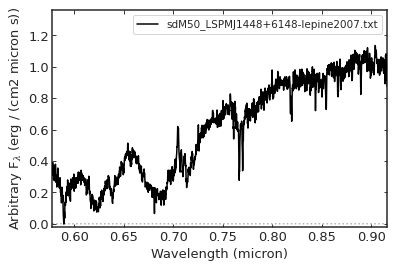

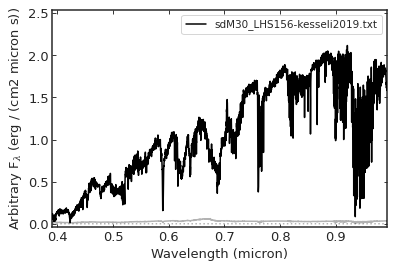

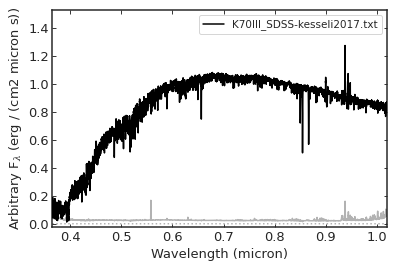

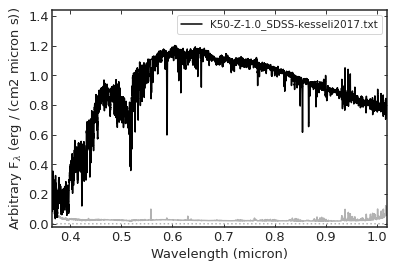

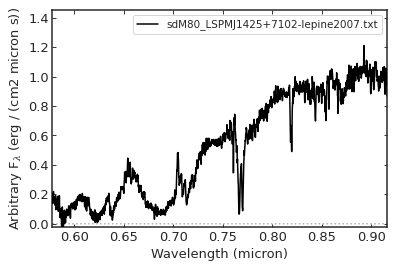

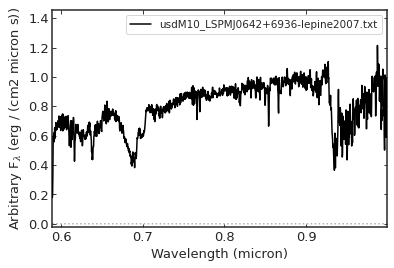

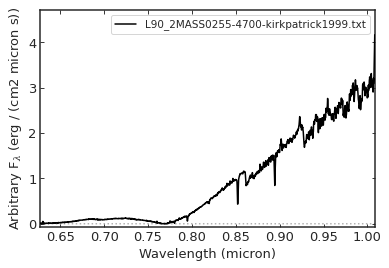

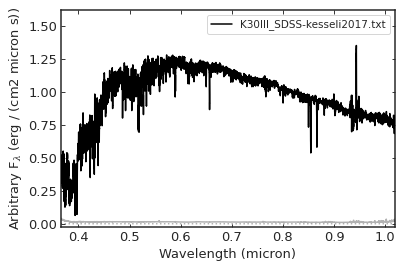

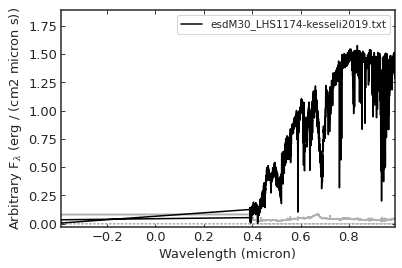

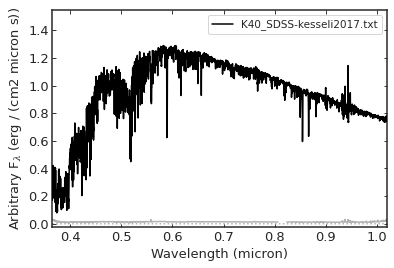

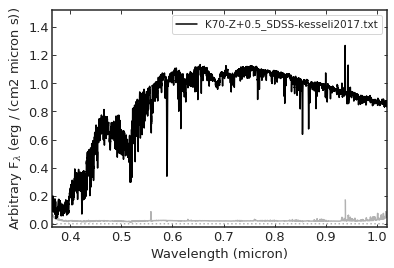

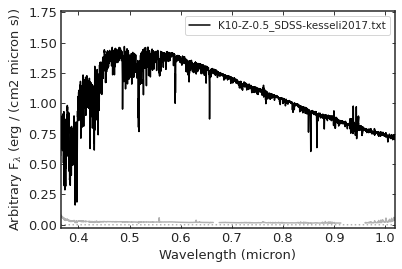

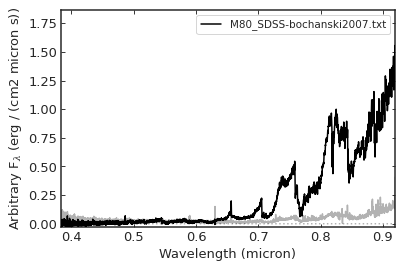

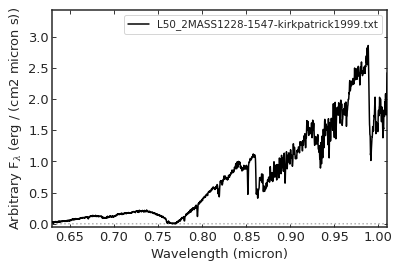

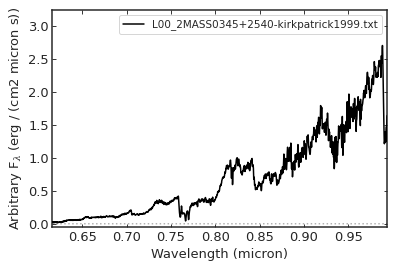

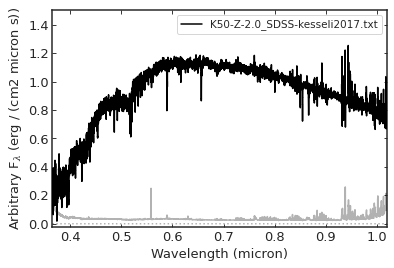

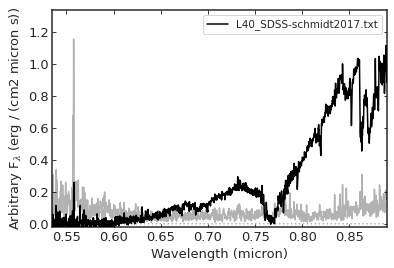

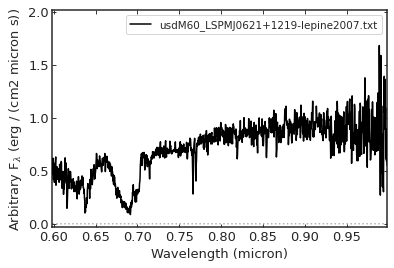

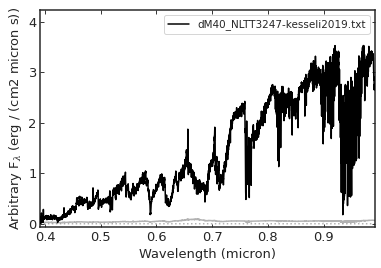

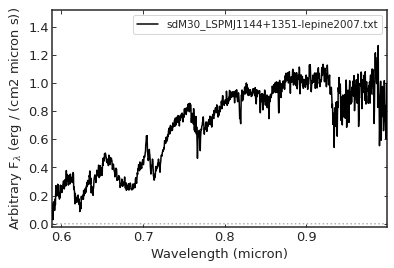

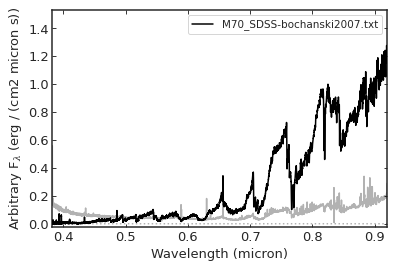

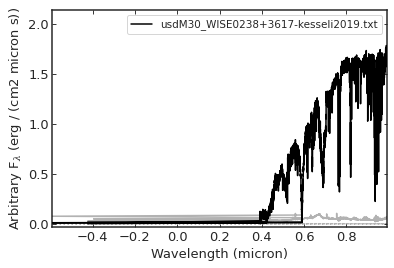

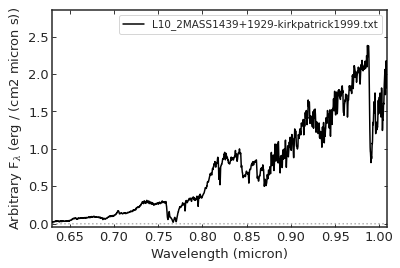

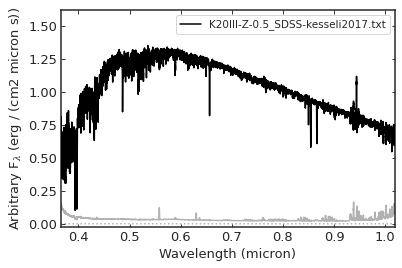

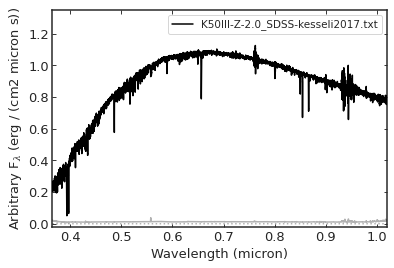

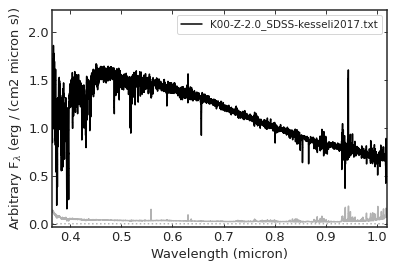

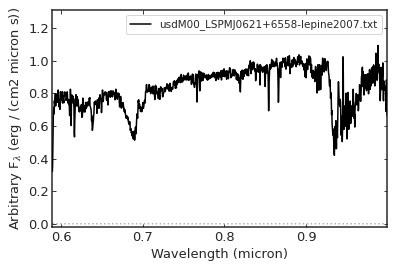

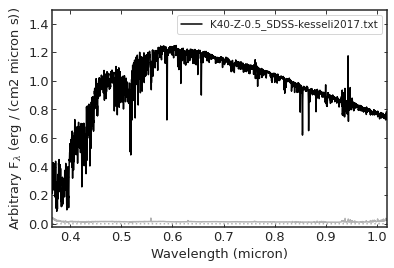

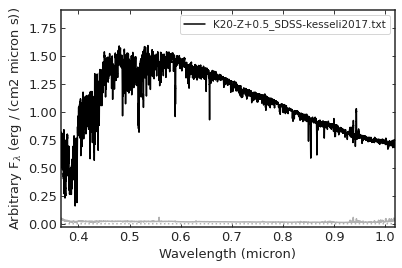

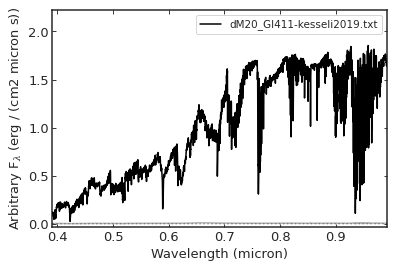

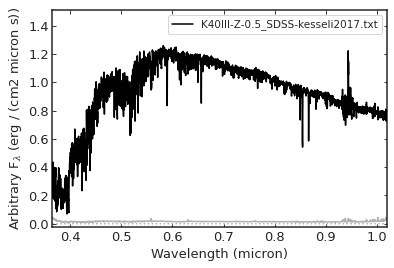

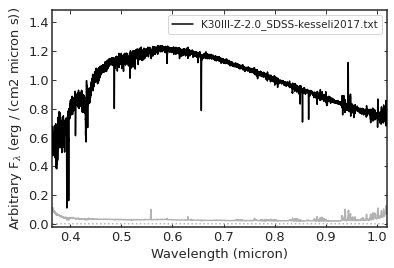

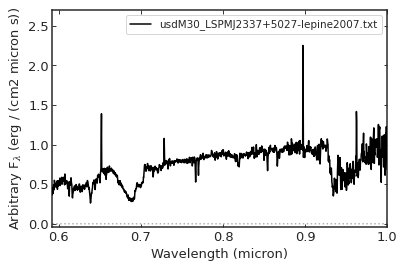

0      [Figure(432x288)]
1      [Figure(432x288)]
2      [Figure(432x288)]
3      [Figure(432x288)]
4      [Figure(432x288)]
             ...        
161    [Figure(432x288)]
162    [Figure(432x288)]
163    [Figure(432x288)]
164    [Figure(432x288)]
165    [Figure(432x288)]
Name: spectra, Length: 162, dtype: object

In [39]:
kast_df.dropna().spectra.apply(lambda x: x.plot())

In [41]:
kast_df.to_pickle(popsims.DATA_FOLDER+'/combined_optical_templates.pkl')